In [134]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pathlib 
import os



# Recuperation des coordonées géo

In [9]:
def build_request_nominatim(country, city):
    
    url = f"https://nominatim.openstreetmap.org/search?country={country}&city={city}&format=json"

    return url



In [13]:

url_request_nominatim = build_request_nominatim("France", "Paris")
url_request_nominatim

'https://nominatim.openstreetmap.org/search?country=France&city=Paris&format=json'

In [28]:
# On récupère la longitude et latitude

def get_lat_long(query):

    headers = {
    'User-Agent': 'ProjetEtudiantMoussa/1.0 (sissokomoussa611@gmail.com)'
}

  
    
    response = requests.get(query, headers=headers)
    data = response.json()

    latitude = data[0]["lat"]
    longitude = data[0]["lon"]

    return float(latitude), float(longitude)

In [29]:
# Vérification du résultat
lat, long = get_lat_long(query=url_request_nominatim)
print(lat, long)
print(type(lat))
print(type(long))

48.8588897 2.320041
<class 'float'>
<class 'float'>


## Récupération des prévisions météorologiques

In [37]:
# Open-meteo.com : afin d'obtenir les données de prédiction météo associés à ces coordonnées. 

def build_request_open_meteo(latitude, longitude):
 
    url = f"https://api.open-meteo.com/v1/forecast?latitude={latitude}&longitude={longitude}&hourly=relativehumidity_2m,windspeed_10m"
    
    return url

In [38]:
# Vérification

url_request_open_meteo = build_request_open_meteo(latitude=lat, longitude=long)
url_request_open_meteo

'https://api.open-meteo.com/v1/forecast?latitude=48.8588897&longitude=2.320041&hourly=relativehumidity_2m,windspeed_10m'

In [57]:
# Obtenir les données de prédictions 
def get_meteo_data(query):
    response = requests.get(query)
    code = response.status_code
   
    if code == 200:
        data = response.json()
        return data
    else:
        print(f"Erreur lors de la requête : {code}")
        return None
    


In [58]:
predictions = get_meteo_data(url_request_open_meteo)
predictions

{'latitude': 48.86,
 'longitude': 2.3199997,
 'generationtime_ms': 0.14770030975341797,
 'utc_offset_seconds': 0,
 'timezone': 'GMT',
 'timezone_abbreviation': 'GMT',
 'elevation': 38.0,
 'hourly_units': {'time': 'iso8601',
  'relativehumidity_2m': '%',
  'windspeed_10m': 'km/h'},
 'hourly': {'time': ['2026-01-20T00:00',
   '2026-01-20T01:00',
   '2026-01-20T02:00',
   '2026-01-20T03:00',
   '2026-01-20T04:00',
   '2026-01-20T05:00',
   '2026-01-20T06:00',
   '2026-01-20T07:00',
   '2026-01-20T08:00',
   '2026-01-20T09:00',
   '2026-01-20T10:00',
   '2026-01-20T11:00',
   '2026-01-20T12:00',
   '2026-01-20T13:00',
   '2026-01-20T14:00',
   '2026-01-20T15:00',
   '2026-01-20T16:00',
   '2026-01-20T17:00',
   '2026-01-20T18:00',
   '2026-01-20T19:00',
   '2026-01-20T20:00',
   '2026-01-20T21:00',
   '2026-01-20T22:00',
   '2026-01-20T23:00',
   '2026-01-21T00:00',
   '2026-01-21T01:00',
   '2026-01-21T02:00',
   '2026-01-21T03:00',
   '2026-01-21T04:00',
   '2026-01-21T05:00',
   '2026-0

In [75]:
### Exploration des fichiers 


# quel type de données 
print(type(predictions))
print(predictions.keys())
# chercher hourly
print(type(predictions["hourly"]))
print(predictions["hourly"].keys())
print(type(predictions["hourly"]["time"]))
print()

# Affichage de données 
print(predictions["hourly"]["time"][:5])
print(predictions["hourly"]["time"][-5:])
print()
print(predictions["hourly"]["relativehumidity_2m"][:5])
print(predictions["hourly"]["windspeed_10m"][:5])


<class 'dict'>
dict_keys(['latitude', 'longitude', 'generationtime_ms', 'utc_offset_seconds', 'timezone', 'timezone_abbreviation', 'elevation', 'hourly_units', 'hourly'])
<class 'dict'>
dict_keys(['time', 'relativehumidity_2m', 'windspeed_10m'])
<class 'list'>

['2026-01-20T00:00', '2026-01-20T01:00', '2026-01-20T02:00', '2026-01-20T03:00', '2026-01-20T04:00']
['2026-01-26T19:00', '2026-01-26T20:00', '2026-01-26T21:00', '2026-01-26T22:00', '2026-01-26T23:00']

[87, 87, 88, 91, 93]
[4.9, 7.4, 8.1, 9.0, 8.2]


## Construction et visualisation d'un bad hair index

In [85]:
# Construction le produit de l'humidité relative et de la vitesse du vent. 
# Il s'agit de mesurer la probabilité d'avoir une mauvaise coiffure en raison des conditions météorologiques.

def preprocess_predictions(predictions):
    raw_data = predictions["hourly"]
    df = pd.DataFrame(raw_data)
    df = df[["time", "relativehumidity_2m", "windspeed_10m"]]
    df = df.rename(columns={
        "time": "date_heure",
        "relativehumidity_2m": "humidite",
        'windspeed_10m': 'vitesse_vent'
    })
    df["date_heure"] = pd.to_datetime(df["date_heure"])

    # Ajout de news features 

    df["jour"] =  df["date_heure"].dt.date # day obs
    df["heure"] =  df["date_heure"].dt.hour # hour obs

    # calcul le bad hair index

    df["bad_hair_index"] = df["humidite"]*df["vitesse_vent"]
    return df 

In [100]:
df_preds = preprocess_predictions(predictions)
df_preds

,date_heure,humidite,vitesse_vent,jour,heure,bad_hair_index
0,2026-01-20 00:00:00,87,4.9,2026-01-20,0,426.3
1,2026-01-20 01:00:00,87,7.4,2026-01-20,1,643.8
2,2026-01-20 02:00:00,88,8.1,2026-01-20,2,712.8
3,2026-01-20 03:00:00,91,9.0,2026-01-20,3,819.0
4,2026-01-20 04:00:00,93,8.2,2026-01-20,4,762.6
...,...,...,...,...,...,...
163,2026-01-26 19:00:00,87,4.7,2026-01-26,19,408.9
164,2026-01-26 20:00:00,89,5.6,2026-01-26,20,498.4
165,2026-01-26 21:00:00,90,6.5,2026-01-26,21,585.0
166,2026-01-26 22:00:00,90,7.0,2026-01-26,22,630.0


In [123]:
# Agreger a deux niveaux le bad hair 
# - Moyenne heure / heure : a quelle heure sera-til préférable de rester à la maison la semaine prochaine ?
# - Moyenne jour / jour : Quel jour sera- til généralement préférable de rester à la maison la semaine prochaine ? 

def plot_agg_avg_bhi(df_preds, agg_var="day")-> None:
    """
    Indice agrégé dans chaque cas et 
    représente le résultat sous forme d'un lineplot

    """
    if agg_var == "day":
        colonne_groupe="jour"
    else:
        colonne_groupe="heure"
    df_agg = df_preds.groupby(colonne_groupe).agg({"bad_hair_index": "mean"})
    df_agg = df_agg.reset_index()

    sns.lineplot(x=colonne_groupe, y="bad_hair_index", data=df_agg)
    plt.ylabel("Moyenne Bad Hair Index")

    if agg_var == "day":
        plt.title("Evolution moyenne  de Bad Hair Index sur 7 jours")
        plt.xlabel("Jour")
    elif agg_var == "heure":
        plt.title("Moyenne BHI par  heure sur 7 jours")
        plt.xlabel("Heure")
    plt.grid(True)
    plt.show()



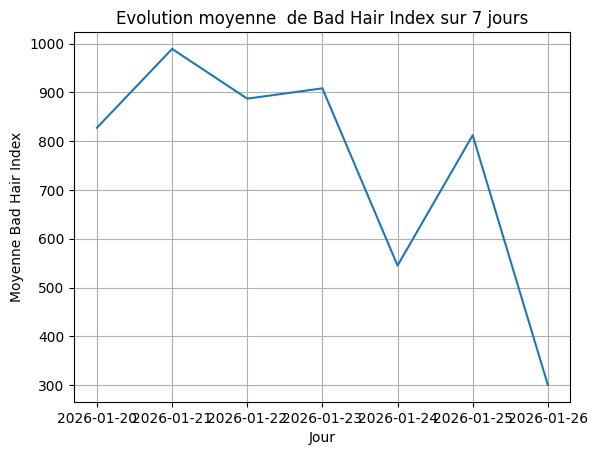

In [124]:
# Vérification du résultat
plot_agg_avg_bhi(df_preds, agg_var="day")

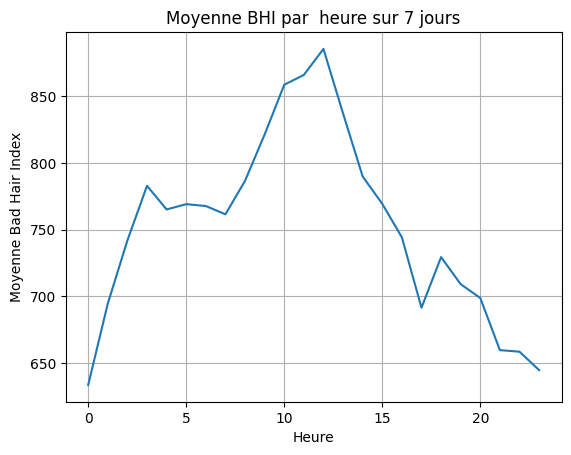

In [139]:
# Vérification du résultat
plot_agg_avg_bhi(df_preds, agg_var="heure")


# Fonction : chef d'orchestre

In [117]:
def main(country, city, agg_var="day"):
    # Get lat, long from Nominatim API
    url_request_nominatim = build_request_nominatim(country, city)
    lat, long = get_lat_long(query=url_request_nominatim)

    # Get wheather predictions
    url_request_open_meteo = build_request_open_meteo(latitude=lat, longitude=long)
    predictions = get_meteo_data(url_request_open_meteo)
    df_preds = preprocess_predictions(predictions)

    # Graphical representation
    plot_agg_avg_bhi(df_preds, agg_var)


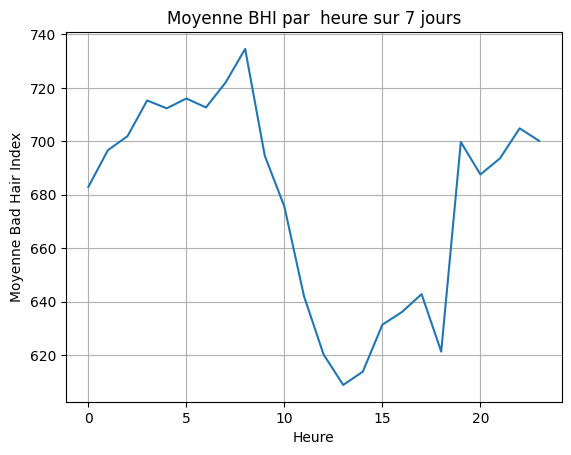

In [ ]:
# Vérification du résultat
main(country="Germany", city="Berlin", agg_var="heure")